# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.


**Основные этапы  выполнения задачи:**

- Загрузить и подготовьте данные;
- Подготовить выборки для обучения моделей;
- Обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг.;
- Проанализировать время обучения, время предсказания и качество моделей;
- Опираясь на критерии заказчика, выбрать лучшую модель, проверить её качество на тестовой выборке.

Для оценки качества моделей использовать метрику RMSE.
Значение метрики RMSE должно быть меньше 2500.

**Описание данных**


Данные находятся в файле /datasets/autos.csv. 


Признаки:
- DateCrawled — дата скачивания анкеты из базы;
- VehicleType — тип автомобильного кузова;
- RegistrationYear — год регистрации автомобиля;
- Gearbox — тип коробки передач;
- Power — мощность (л. с.);
- Model — модель автомобиля;
- Kilometer — пробег (км);
- RegistrationMonth — месяц регистрации автомобиля;
- FuelType — тип топлива;
- Brand — марка автомобиля;
- Repaired — была машина в ремонте или нет;
- DateCreated — дата создания анкеты;
- NumberOfPictures — количество фотографий автомобиля;
- PostalCode — почтовый индекс владельца анкеты (пользователя);
- LastSeen — дата последней активности пользователя.


Целевой признак: Price — цена (евро)

In [1]:
!pip install phik -q
!pip install --upgrade scikit-learn -q
!pip install category-encoders -q

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import phik
import lightgbm as lgb
import time

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from category_encoders import TargetEncoder 
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
from sklearn.metrics import make_scorer
from scipy.stats import randint, uniform
from sklearn.model_selection import cross_validate

RANDOM = 42

## Подготовка данных

### Считаем CSV-файлы с данными с помощью библиотеки pandas и сохраним его в датафрейм

In [2]:
autos = pd.read_csv('/datasets/autos.csv')

### Изучим информацию о датафреймах

In [3]:
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Типы данных соответствуют действительности, в данных есть пропуски. Для удобства переименуем названия столбцов.


In [5]:
autos.columns = autos.columns.str.replace(r'([a-z])([A-Z])', r'\1_\2', regex=True).str.lower()

### Проверим на наличие пропусков и дубликатов

In [7]:
def skips_dulicates(data):
    total_missing = data.isna().sum().sum()
    if total_missing > 0:
        print(f"Пропуски найдены, общее количество пропусков: {total_missing}")
        print("Пропуски по столбцам:")
        print(data.isna().sum())
    else:
        print("Пропусков нет.")
    duplicate_count = data.duplicated().sum()
    if duplicate_count > 0:
        print(f"Количество явных дубликатов: {duplicate_count}")
    else:
        print("Дубликатов нет.")
    return data

In [8]:
skips_dulicates(autos);

Пропуски найдены, общее количество пропусков: 181077
Пропуски по столбцам:
date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64
Количество явных дубликатов: 4


In [9]:
# удалим явные дубликаты
autos = autos.drop_duplicates()

In [10]:
autos['vehicle_type'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [11]:
autos['vehicle_type'] = autos.groupby('brand')['vehicle_type'].transform(
    lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x.fillna('unknown')
)

In [12]:
autos['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [13]:
autos['gearbox'].fillna('unknown', inplace=True)

In [14]:
autos['model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [15]:
autos['model'] = autos.groupby('brand')['model'].transform(
    lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x.fillna('unknown')
)

In [16]:
autos['fuel_type'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [17]:
# petrol и gasoline - одно и то же, переименуем gasoline в petrol
autos['fuel_type'] = autos['fuel_type'].replace(['gasoline'], 'petrol')
autos['fuel_type'].fillna('unknown', inplace=True)

In [18]:
autos['repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

In [19]:
autos['repaired'].fillna('unknown', inplace=True)

In [20]:
skips_dulicates(autos);

Пропусков нет.
Дубликатов нет.


### Проведем исследовательский анализ данных

In [21]:
def cat_variable_visualization(data, column, ax):
    counts = data[column].value_counts().sort_values(ascending=False)
    counts.plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')
    
    ax.set_title(f'Распределение: {column}', fontsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('Количество', fontsize=10)
    ax.tick_params(axis='x', rotation=45) 
    ax.grid(axis='y', linestyle='--', alpha=0.7)

In [22]:
autos.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


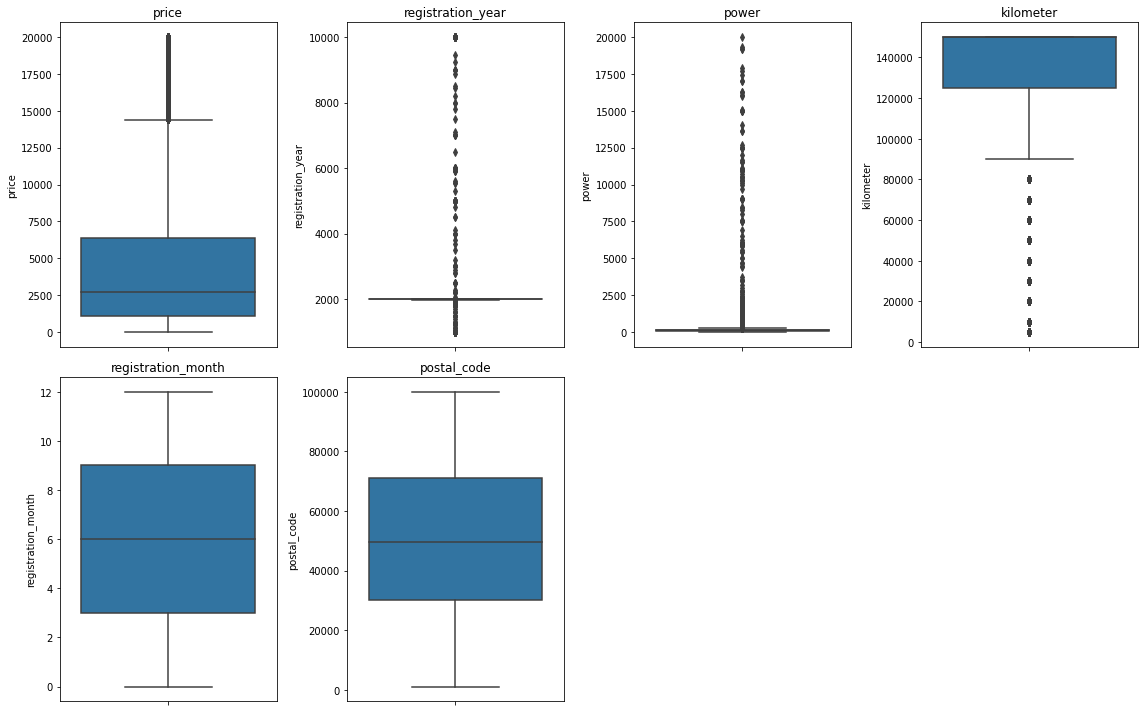

In [23]:
autos = autos.drop(['date_crawled', 'last_seen', 'number_of_pictures'], axis = 1)

num_cols = autos.select_dtypes(include=['number']).columns

n_cols = 4  
n_rows = math.ceil(len(num_cols) / n_cols) 


fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 4, n_rows * 5))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(data=autos, y=col, ax=axes[i])
    axes[i].set_title(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

Среди признаков есть неинформативные: `date_crawled`, `last_seen`, `number_of_pictures`. От данных признаков стоимость автомобилей никак не зависит.

В столбце `price` присутствуют аномальные значения (стоимость 0). `registration_year` стоит ограничить от создания первого серийнгого автомобиля в 1886 до 2016 года. В `power` исключим значения 0 и ограничим до 2000. В `kilometer` аномальных значений нет, так как пробег может быть малениким. 

In [24]:
autos['registration_month'] = autos['registration_month'].replace(0, 1)

autos = autos[autos['price'] > 0]

autos = autos[((autos['registration_year'] >= 1886) & (autos['registration_year'] < 2016)) 
             | ((autos['registration_year'] == 2016) & (autos['registration_month'] <= 4))]

autos['power'] = autos.groupby(['brand', 'model'])['power'].transform(
    lambda x: x.replace(0, x.median()) if x.median() > 0 else x.replace(0, 100)
)

autos = autos[(autos['power'] > 0) & (autos['power'] <= 2000)]

autos['date_created'] = pd.to_datetime(autos['date_created'], format='%Y-%m-%d %H:%M:%S')
autos['created_year'] = autos['date_created'].dt.year
autos['created_month'] = autos['date_created'].dt.month

valid_year = (
    (autos['registration_year'] < autos['created_year']) | 
    (
        (autos['registration_year'] == autos['created_year']) & 
        (autos['registration_month'] <= autos['created_month'])
    )
)

autos = autos[valid_year]

autos['postal_code'] = autos['postal_code'].astype(str).str.zfill(5)  
autos['region'] = autos['postal_code'].str[:2] 

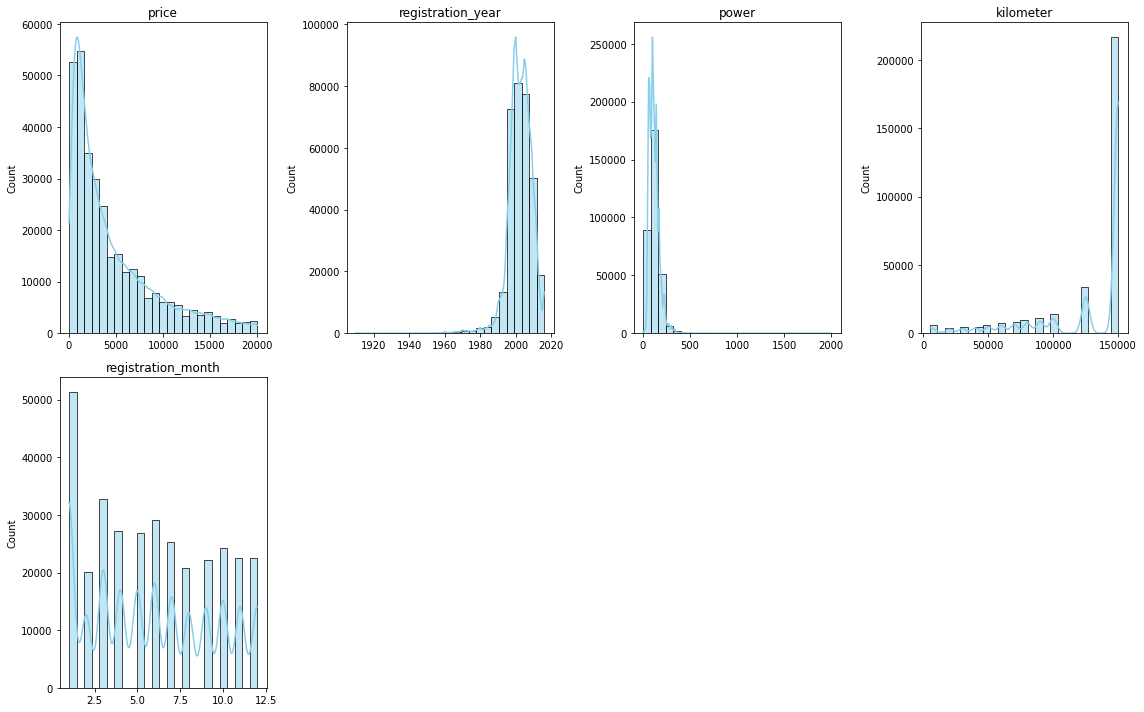

In [25]:
n_cols = 4  
num_cols = num_cols.drop('postal_code')
n_rows = math.ceil(len(num_cols) / n_cols)  
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 4, n_rows * 5))

axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(autos[col], bins=25, kde=True, ax=axes[i], color="skyblue", edgecolor="black")
    axes[i].set_title(col)
    axes[i].set_xlabel("")
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

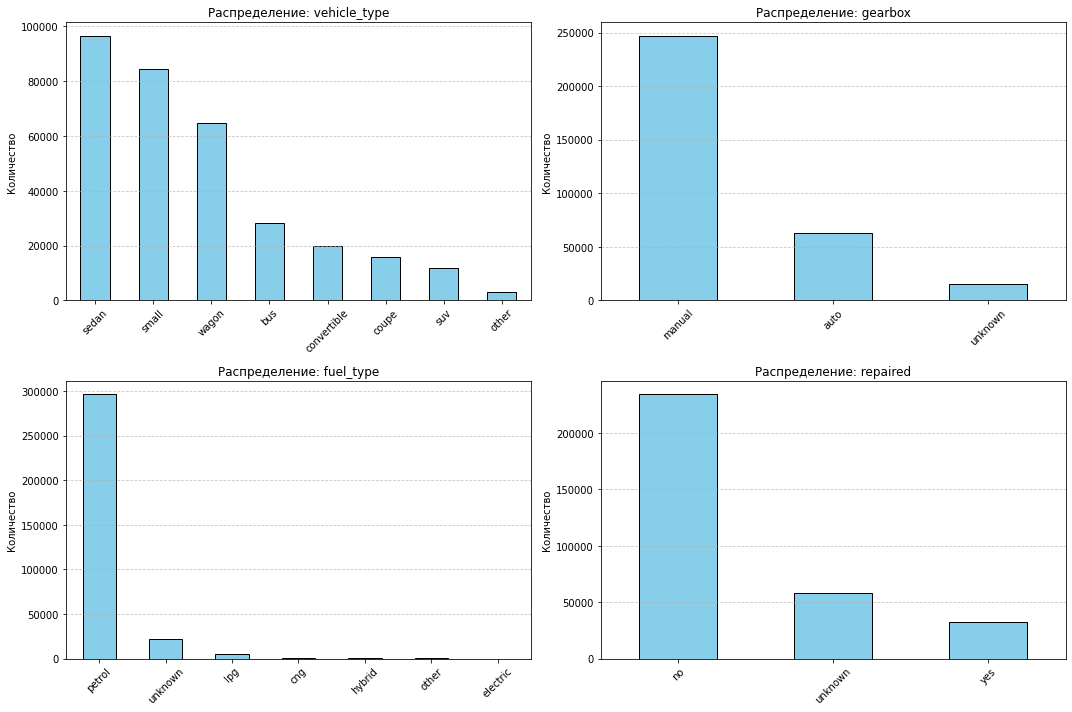

In [26]:
columns = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired']  

fig, axes = plt.subplots(2, 2, figsize=(15, 10)) 

axes = axes.flatten()

for i, column in enumerate(columns):
    cat_variable_visualization(autos, column, axes[i])
    
for ax in axes[len(columns):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

В качественных переменных наблюдается сильныйй дисбаланс классов.

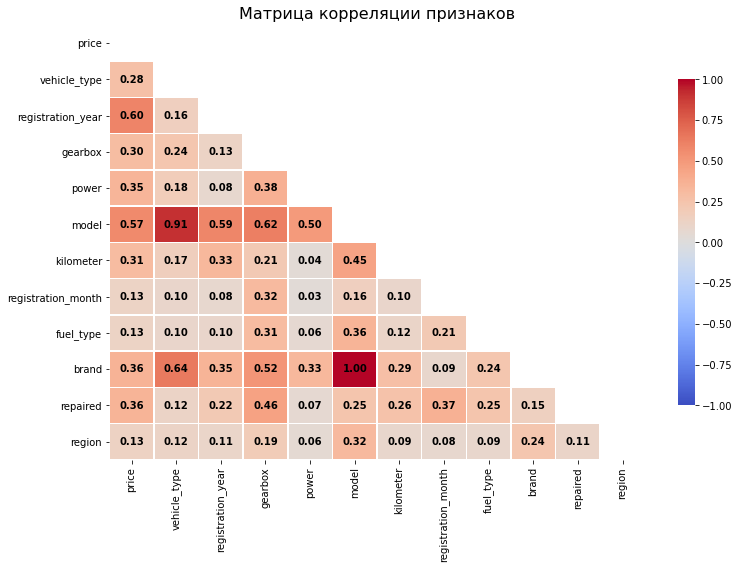

In [27]:
autos = autos.drop(['postal_code', 'date_created', 'created_year', 'created_month'], axis = 1)

interval_cols = [
    'price', 'registration_year', 'power', 'kilometer'
]

phik_matrix = autos.phik_matrix(interval_cols=interval_cols)
mask = np.triu(np.ones_like(phik_matrix, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(
    phik_matrix,
    annot=True,          
    fmt=".2f",           
    cmap="coolwarm",     
    mask=mask,          
    linewidths=0.5,     
    cbar_kws={"shrink": 0.75},  
    vmin=-1, vmax=1,     
    annot_kws={"size": 10, "weight": "bold", "color": "black"}  
)

plt.title("Матрица корреляции признаков", fontsize=16)
plt.show()

Наиболее значимые признаки для цены:

- registration_year (корреляция 0.6): более новые автомобили, как правило, дороже.

- model (0.57): модель автомобиля сильно влияет на цену.

Присутсвует мультиколлинеарность: между model и brand корреляция 1.00, что указывает на полную линейную зависимость. Один из этих признаков стоит исключить (исключим brand, так как он слабее коррелирует с целевым признаком).

In [28]:
autos = autos.drop(['brand'], axis = 1)

**Были найдены и запонены пропуски, удалены явные дубликаты. Среди признаков были найдены неинформативные: date_crawled, postal_code, last_seen, number_of_pictures. От данных признаков стоимость автомобилей никак не зависит, они были удалены. Данные были очищены от выбросов.**

## Обучение моделей

In [29]:
autos = autos.astype({'vehicle_type':'category',
                                  'gearbox':'category',
                                  'model':'category',
                                  'fuel_type':'category',
                                  'repaired':'category',
                                  'region': 'category',
                                  'registration_month': 'category'})

#Разделим данные

target = autos['price']
features = autos.drop('price', axis=1)

X_temp, X_test, y_temp, y_test = train_test_split(features, target, test_size=0.2, random_state=RANDOM)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=RANDOM)

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM)


categorical_high = ['model', 'region']
categorical_low = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired', 'registration_month']
numerical_features = ['power', 'kilometer', 'registration_year']

preprocessor_RF = ColumnTransformer([
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_high),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_low)
], remainder='passthrough')

preprocessor_LR = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_low + categorical_high),
    ('scaler', StandardScaler(), numerical_features)
])

In [30]:
models = {
    "LinearRegression": Pipeline([
        ('preprocessor', preprocessor_LR),
        ('model', LinearRegression())
    ]),
    
    "RandomForest": Pipeline([
        ('preprocessor', preprocessor_RF),
        ('model', RandomForestRegressor(random_state=RANDOM))
    ]),
    
    "LightGBM": LGBMRegressor(
        num_leaves=31,
        learning_rate=0.1,
        n_estimators=500,
        categorical_feature=categorical_low + categorical_high,
        random_state=RANDOM,
        verbosity=-1
    ),
    
    "CatBoost": CatBoostRegressor(
        iterations=1000,
        learning_rate=0.1,
        cat_features=categorical_low + categorical_high,
        random_state=RANDOM,
        verbose=0
    )
}

In [31]:
# Подбор гиперпараметров для RandomForest
param_dist_fast = {
    'model__n_estimators': randint(30, 50), 
    'model__max_depth': [5, 7], 
    'model__max_features': ['sqrt']
}

In [32]:
random_search = RandomizedSearchCV(
    models["RandomForest"],
    param_distributions=param_dist_fast,
    n_iter=5,  
    cv=2,  
    scoring='neg_root_mean_squared_error',
    n_jobs=2, 
    random_state=RANDOM,
    verbose=1
)

In [33]:
random_search.fit(X_temp, y_temp)
best_rf = random_search.best_estimator_

Fitting 2 folds for each of 5 candidates, totalling 10 fits


In [34]:
# Обучение с кросс-валидацией
results = {}
model_times = {}

rf_results = {
    'fit_time': random_search.cv_results_['mean_fit_time'][random_search.best_index_],
    'score_time': random_search.cv_results_['mean_score_time'][random_search.best_index_],
    'test_score': random_search.best_score_
}
results["RandomForest"] = {
    'RMSE_mean': -rf_results['test_score'],
    'RMSE_std': 0.0,  
    'fit_time': rf_results['fit_time'],
    'pred_time': rf_results['score_time']
}


for name, model in models.items():
    if name == "RandomForest":
        continue
    
    start_time = time.time()
    
    if name in ["LightGBM", "CatBoost"]:
        fold_scores = []
        fit_times = []
        pred_times = []
        
        for train_idx, val_idx in kf.split(X_temp):
            X_fold_train, X_fold_val = X_temp.iloc[train_idx], X_temp.iloc[val_idx]
            y_fold_train, y_fold_val = y_temp.iloc[train_idx], y_temp.iloc[val_idx]
            
            start_fit = time.time()
            model.fit(
                X_fold_train, y_fold_train,
                eval_set=(X_fold_val, y_fold_val),
                early_stopping_rounds=50,
                verbose=0
            )
            fit_time = time.time() - start_fit
            
            start_pred = time.time()
            pred = model.predict(X_fold_val)
            pred_time = time.time() - start_pred
            fold_scores.append(np.sqrt(mean_squared_error(y_fold_val, pred)))  
            fit_times.append(fit_time)
            pred_times.append(pred_time)
        
        results[name] = {
            'RMSE_mean': np.mean(fold_scores),
            'RMSE_std': np.std(fold_scores),
            'fit_time': np.mean(fit_times),
            'pred_time': np.mean(pred_times)
        }
        
    else:
        cv_results = cross_validate(
            model,
            X_temp,
            y_temp,
            cv=kf,
            scoring='neg_root_mean_squared_error',
            return_train_score=True,
            return_estimator=True
        )
        
        results[name] = {
            'RMSE_mean': -cv_results['test_score'].mean(),
            'RMSE_std': cv_results['test_score'].std(),
            'fit_time': cv_results['fit_time'].mean(),
            'pred_time': cv_results['score_time'].mean()
        }

metrics_df = pd.DataFrame({
    'RMSE_mean': [results[name]['RMSE_mean'] for name in results],
    'RMSE_std': [results[name]['RMSE_std'] for name in results],
    'Среднее время обучения (сек)': [results[name]['fit_time'] for name in results],
    'Среднее время предсказания (сек)': [results[name]['pred_time'] for name in results]
}, index=results.keys())

print("\nДетализированные результаты:")
print(metrics_df)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback 


Детализированные результаты:
                    RMSE_mean   RMSE_std  Среднее время обучения (сек)  \
RandomForest      2581.442642   0.000000                     12.268236   
LinearRegression  2836.776989  13.712529                     29.105409   
LightGBM          1616.411876  17.992200                    581.112479   
CatBoost          1671.992222  17.945869                    296.720620   

                  Среднее время предсказания (сек)  
RandomForest                              1.630499  
LinearRegression                          0.284620  
LightGBM                                  2.622980  
CatBoost                                  0.792969  


## Анализ моделей

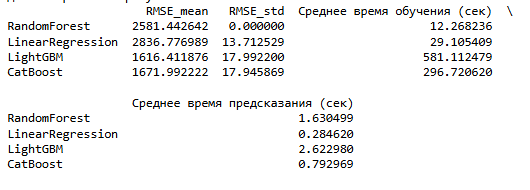



Лучшее качество у LightGBM (1616). Самой быстрой, с учетом кросс-валидации, оказалась RandomForest (10 сек).


Предпочтительнее выбрать LightGBM, качестве наилучшее, обучается и предсказывает быстро (без  кросс-валидации)

In [36]:
best_model_name = metrics_df['RMSE_mean'].idxmin() 
best_model = models[best_model_name]

if best_model_name == "RandomForest":
    best_model = best_rf  

best_model.fit(X_temp, y_temp)

# Финальная оценка
%time
y_pred = best_model.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\nФинальный RMSE ({best_model_name}): {final_rmse:.2f}")

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.63 µs

Финальный RMSE (LightGBM): 1629.13


## Общий вывод

**Описание проекта**

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.


**Основные этапы выполнения задачи:**

- Загрузить и подготовьте данные;
- Подготовить выборки для обучения моделей;
- Обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг.;
- Проанализировать время обучения, время предсказания и качество моделей;
- Опираясь на критерии заказчика, выбрать лучшую модель, проверить её качество на тестовой выборке.
- Для оценки качества моделей использовать метрику RMSE. Значение метрики RMSE должно быть меньше 2500.


В ходе выполнения работы было обнаружено, что типы данных соответствуют действительности, в данных есть пропуски. Для удобства  названия столбцов были переименованы в змеином регистре. Были удалены дубликаты, некоторые пропуски были с некоторой степенью точности восстановленны друг на основе друга. 

Проведен исследовательский анализ данных. Среди признаков есть неинформативные, они были удалены. Были убраны аномальные значения некоторых признаков.

Были обучены модели: LinearRegression, RandomForest, LightGBM, CatBoost. Лучшее качество у LightGBM (1616). Самой быстрой, с учетом кросс-валидации, оказалась RandomForest (51.78 сек).

Предпочтительнее выбрать LightGBM, качестве наилучшее, обучается и предсказывает быстро (без кросс-валидации). 